In [1]:
# Core libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools

# Data preprocessing
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline

# Metrics and evaluation
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, make_scorer
from sklearn.inspection import permutation_importance

# Machine learning models
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression

# Visualization tools
from statsmodels.graphics.gofplots import qqplot
import seaborn as sns

# TensorFlow/Keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, Input, LayerNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay

2025-01-22 12:19:15.196099: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-01-22 12:19:15.269705: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


# Load and clean data

In [2]:
# Read the CSV, treating all fields as strings
data = pd.read_csv('MiningProcess_Flotation_Plant_Database.csv', parse_dates=True,decimal=',')

#Convert column 'date' to datetime format
data['date']=pd.to_datetime(data['date'])


In [3]:
#missing hours in the date column 

# Create a complete range of hourly timestamps
full_range = pd.date_range(start=data['date'].min(), end=data['date'].max(), freq='H')

# Create a DataFrame from the full range
full_range_df = pd.DataFrame(full_range, columns=['date'])

# Merge the full range with actual data to identify missing hours
merged = full_range_df.merge(data, on='date', how='left', indicator=True)

# Identify missing hours
missing_hours = merged[merged['_merge'] == 'left_only']['date']

# Extract the days that are missing hours
missing_days = missing_hours.dt.date.unique()

print("Days Missing Hours:")
for day in missing_days:
    print(f"Date: {day}")
    day_missing_hours = missing_hours[missing_hours.dt.date == day]
    print(f"Missing Hours: {day_missing_hours.dt.hour.values}")
    print()

/tmp/ipykernel_416160/1613406208.py:4: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  full_range = pd.date_range(start=data['date'].min(), end=data['date'].max(), freq='H')


Days Missing Hours:
Date: 2017-03-16
Missing Hours: [ 6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]

Date: 2017-03-17
Missing Hours: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]

Date: 2017-03-18
Missing Hours: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]

Date: 2017-03-19
Missing Hours: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]

Date: 2017-03-20
Missing Hours: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]

Date: 2017-03-21
Missing Hours: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]

Date: 2017-03-22
Missing Hours: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]

Date: 2017-03-23
Missing Hours: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]

Date: 2017-03-24
Missing Hours: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]

Date: 2017-03-25
Missing Hours: [ 0

In [4]:
# Seems like the plant when in to shut down from 2017-03-16 to 2017-03-29
#We are going to work only with data after 2017-03-29 11 pm since LSTM is time dependent
df = data.copy()
df.set_index('date',inplace=True)
df = df[df.index > '2017-03-29 11:00:00']

In [5]:
## Resample by hour
df=df.resample('H').mean()

/tmp/ipykernel_416160/1729076469.py:2: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df=df.resample('H').mean()


In [6]:
df.isna().sum()

% Iron Feed                     0
% Silica Feed                   0
Starch Flow                     0
Amina Flow                      0
Ore Pulp Flow                   0
Ore Pulp pH                     0
Ore Pulp Density                0
Flotation Column 01 Air Flow    0
Flotation Column 02 Air Flow    0
Flotation Column 03 Air Flow    0
Flotation Column 04 Air Flow    0
Flotation Column 05 Air Flow    0
Flotation Column 06 Air Flow    0
Flotation Column 07 Air Flow    0
Flotation Column 01 Level       0
Flotation Column 02 Level       0
Flotation Column 03 Level       0
Flotation Column 04 Level       0
Flotation Column 05 Level       0
Flotation Column 06 Level       0
Flotation Column 07 Level       0
% Iron Concentrate              0
% Silica Concentrate            0
dtype: int64

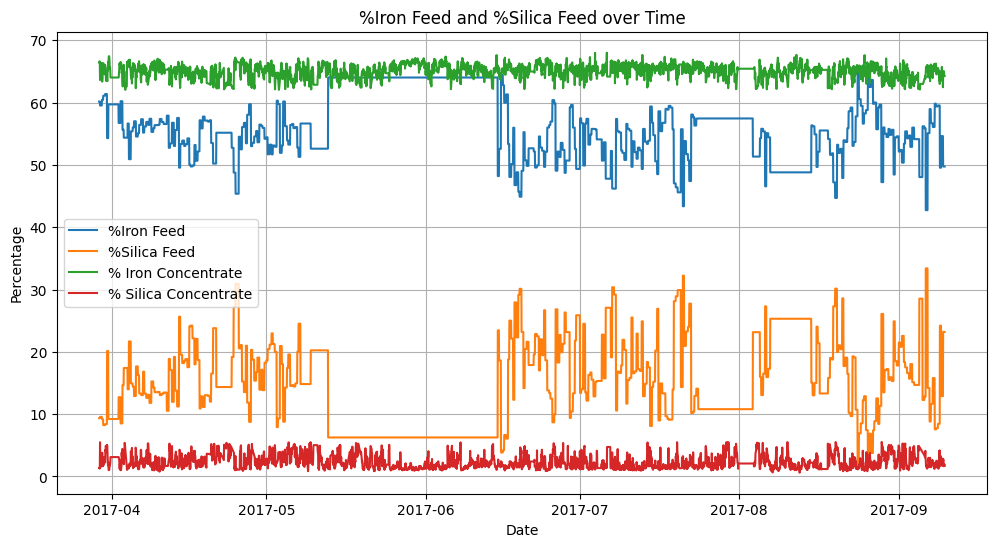

In [7]:
# Plotting
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['% Iron Feed'], label='%Iron Feed')
plt.plot(df.index, df['% Silica Feed'], label='%Silica Feed')
plt.plot(df.index, df['% Iron Concentrate'], label='% Iron Concentrate')
plt.plot(df.index, df['% Silica Concentrate'], label='% Silica Concentrate')
plt.xlabel('Date')
plt.ylabel('Percentage')
plt.title('%Iron Feed and %Silica Feed over Time')
plt.legend()
plt.grid(True)
plt.show()

# Feature selection and preparation for LSTM model

In [8]:

def select_features(data, target_column, corr_threshold=0.1, collinearity_threshold=0.9):
    """
    Select features by dropping those with low correlation to the target
    and high multicollinearity.

    Parameters:
    - data: DataFrame containing the dataset.
    - target_column: Name of the target column as a string.
    - corr_threshold: Minimum absolute correlation with the target to retain a feature.
    - collinearity_threshold: Maximum pairwise correlation between features.

    Returns:
    - reduced_data: DataFrame with selected features.
    - dropped_features: List of features dropped during selection.
    """
    # Step 1: Calculate correlation with the target
    target_corr = data.corr()[target_column].drop(target_column)  # Exclude target
    high_corr_features = target_corr[abs(target_corr) >= corr_threshold].index.tolist()

    # Step 2: Filter dataset to include only features with high correlation to the target
    filtered_data = data[high_corr_features + [target_column]]
    
    # Step 3: Check for multicollinearity (pairwise feature correlation)
    corr_matrix = filtered_data.corr().abs()
    dropped_features = set()

    for feature in high_corr_features:
        if feature in dropped_features:
            continue
        # Find features highly correlated with the current feature
        high_corr_with_feature = corr_matrix[feature][corr_matrix[feature] > collinearity_threshold].index.tolist()
        # Exclude the current feature and add others to the drop list
        high_corr_with_feature.remove(feature)
        dropped_features.update(high_corr_with_feature)

    # Step 4: Remove highly correlated features
    final_features = [f for f in high_corr_features if f not in dropped_features]
    reduced_data = data[final_features + [target_column]]

    return reduced_data, list(dropped_features)


# Example Usage:
# Assuming `df` is your DataFrame and `% Silica Concentrate` is the target
target_column = '% Silica Concentrate'
selected_data, dropped_features = select_features(df, target_column, corr_threshold=0.1, collinearity_threshold=0.9)

print("Selected Features:\n", selected_data.columns.tolist())
print("Dropped Features:\n", dropped_features)


Selected Features:
 ['Amina Flow', 'Ore Pulp pH', 'Flotation Column 01 Air Flow', 'Flotation Column 02 Air Flow', 'Flotation Column 04 Level', 'Flotation Column 05 Level', 'Flotation Column 06 Level', 'Flotation Column 07 Level', '% Iron Concentrate', '% Silica Concentrate']
Dropped Features:
 ['Flotation Column 03 Air Flow']


In [9]:
df=df[selected_data.columns.tolist()]

In [10]:
# Interaction between air flows and pulp pH.
df['Air_pH_Interaction'] = df['Flotation Column 01 Air Flow'] * df['Ore Pulp pH']


In [11]:
# Calculate the number of rows to select
train_size = int(len(df) * 0.7)

# Select the first 70% of the rows for training
df_train, df_test = df.iloc[:train_size], df.iloc[train_size:]


In [12]:
# Normalize data
scaler = MinMaxScaler()

df_train = pd.DataFrame(scaler.fit_transform(df_train), columns=scaler.get_feature_names_out())
df_test = pd.DataFrame(scaler.transform(df_test), columns=scaler.get_feature_names_out())

In [13]:

def window_slicing(n_hours,df):
    
    # Prepare the dataset
    X, y = [], []

    # Iterate over the dataframe to create sequences
    for i in range(len(df) - n_hours):
        # Get the input sequence
        X_sequence = df.iloc[i:i + n_hours].values
        # Get the target value for the next hour
        #y_sequence = df.iloc[i + n_hours][['% Silica Concentrate','% Iron Concentrate']].values
        y_sequence = df.iloc[i + n_hours][['% Silica Concentrate']].values
        X.append(X_sequence)
        y.append(y_sequence)

    # Convert lists to numpy arrays
    X = np.array(X)
    y = np.array(y)
    y=np.expand_dims(y, axis=1)

    return X, y


# LSTM Model

In [14]:
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.layers import Dropout
from tensorflow.keras import regularizers

def create_lstm_model(initial_learning_rate, decay_steps, decay_rate,neurons,input_shape):

     # Input layer
    inputs = Input(shape=input_shape)
    
    # Shared LSTM layers with regularization
    
    x = LSTM(units=neurons, activation='tanh', return_sequences=True)(inputs)
    
    x = LSTM(units=neurons, activation='tanh', return_sequences=True)(x)
    
    x = LSTM(units=neurons, activation='tanh', return_sequences=True)(x)
    
    x = LSTM(units=neurons, activation='tanh', return_sequences=False)(x)

    
        # Separate output layers for each target
    output = Dense(1, activation='linear', name='output')(x)

    # Define the model
    model = Model(inputs=inputs, outputs=output)
    

    lr_schedule = ExponentialDecay(
    initial_learning_rate, 
    decay_steps = decay_steps, 
    decay_rate = decay_rate)
    
    # Using Adam optimizer 
    optimizer = Adam(learning_rate=lr_schedule)
    
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    
    return model

In [15]:
def fit_model(df_train,df_test,seq_length,validation_split,batch_size,epochs, initial_learning_rate,decay_steps,decay_rate,neurons):
    
        #train data
    X_train,y_train = window_slicing(seq_length,df_train)
    
    shape = (X_train.shape[1],X_train.shape[2])
    
        # Create the model
    model = create_lstm_model(initial_learning_rate, decay_steps, decay_rate,neurons,input_shape=shape)


    
    # train the LSTM model

    es = EarlyStopping(patience=10, restore_best_weights=True)

    history = model.fit(X_train, y_train,
                        validation_split=validation_split,
                        batch_size=batch_size, 
                        epochs=epochs, 
                        callbacks=[es],
                        verbose=1)
    
    X_test, y_test = window_slicing(seq_length,df_test)
    
    return history,model, X_test, y_test

In [16]:
# Define parameter grids using dictionaries
param_grid = {
    'seq_length': [3,6,12],
    'validation_split': [0.2, 0.3],
    'batch_size': [16, 32],
    'epochs': [50, 100],
    'initial_learning_rate': [0.01, 0.001],
    'decay_steps': [1000, 2000],
    'decay_rate': [0.01, 0.001],
    'neurons': [30, 50,100]
}

#576 possible combinations


In [ ]:
# Get keys and values from param_grid
param_names = list(param_grid.keys())
param_values = list(param_grid.values())

best_r2_score = -float('inf')
best_params = None

# Create iterator over all parameter combinations
param_combinations = itertools.product(*param_values)

n=0
# Iterate over parameter combinations
for values in param_combinations:
    params = dict(zip(param_names, values))
    
    # Call fit_model function with current parameter combination
    print(f"Training with parameters: {params}")
    
    history, model,X_test,y_test = fit_model(df_train,df_test, **params)
    
    y_test_flat = y_test.reshape(-1, 1)
    
    # Make predictions on the test set
    pred = model.predict(X_test)
    
    # Calculate R^2 score
    r2 = r2_score(y_test_flat, pred)
    
    print(f"R^2 Score: {r2}")
    
    # Check if current combination is the best
    if r2 > best_r2_score:
        best_r2_score = r2
        best_params = params
        model = model
        history=history
        
        print("Found new best parameters.")
    
    n=n+1
    print(f"Training {n} completed.\n")

# Print the best parameters found
print("Best Parameters:")
print(best_params)
print(f"Best R^2 Score: {best_r2_score}")

Training with parameters: {'seq_length': 3, 'validation_split': 0.2, 'batch_size': 16, 'epochs': 50, 'initial_learning_rate': 0.01, 'decay_steps': 1000, 'decay_rate': 0.01, 'neurons': 30}


2025-01-22 12:19:18.467922: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/50
138/138 [==============================] - 5s 15ms/step - loss: 0.0396 - mae: 0.1511 - val_loss: 0.0272 - val_mae: 0.1145
Epoch 2/50
138/138 [==============================] - 1s 7ms/step - loss: 0.0232 - mae: 0.1110 - val_loss: 0.0248 - val_mae: 0.1040
Epoch 3/50
138/138 [==============================] - 1s 7ms/step - loss: 0.0222 - mae: 0.1067 - val_loss: 0.0252 - val_mae: 0.1137
Epoch 4/50
138/138 [==============================] - 1s 6ms/step - loss: 0.0217 - mae: 0.1056 - val_loss: 0.0241 - val_mae: 0.0993
Epoch 5/50
138/138 [==============================] - 0s 303us/step - loss: 0.0209 - mae: 0.1020 - val_loss: 0.0236 - val_mae: 0.0993
Epoch 6/50
138/138 [==============================] - 1s 6ms/step - loss: 0.0207 - mae: 0.1005 - val_loss: 0.0233 - val_mae: 0.1011
Epoch 7/50
138/138 [==============================] - 1s 6ms/step - loss: 0.0207 - mae: 0.1017 - val_loss: 0.0234 - val_mae: 0.0996
Epoch 8/50
138/138 [==============================] - 1s 6ms/step - loss:

Epoch 6/50
138/138 [==============================] - 1s 6ms/step - loss: 0.0207 - mae: 0.1012 - val_loss: 0.0232 - val_mae: 0.1011
Epoch 7/50
138/138 [==============================] - 0s 668us/step - loss: 0.0207 - mae: 0.1011 - val_loss: 0.0232 - val_mae: 0.1010
Epoch 8/50
138/138 [==============================] - 1s 6ms/step - loss: 0.0207 - mae: 0.1011 - val_loss: 0.0232 - val_mae: 0.1011
Epoch 9/50
138/138 [==============================] - 1s 6ms/step - loss: 0.0207 - mae: 0.1012 - val_loss: 0.0232 - val_mae: 0.1011
Epoch 10/50
138/138 [==============================] - 1s 7ms/step - loss: 0.0206 - mae: 0.1012 - val_loss: 0.0232 - val_mae: 0.1011
Epoch 11/50
138/138 [==============================] - 1s 6ms/step - loss: 0.0206 - mae: 0.1012 - val_loss: 0.0232 - val_mae: 0.1011
Epoch 12/50
138/138 [==============================] - 1s 6ms/step - loss: 0.0206 - mae: 0.1012 - val_loss: 0.0232 - val_mae: 0.1011
Epoch 13/50
138/138 [==============================] - 1s 6ms/step - lo

138/138 [==============================] - 1s 7ms/step - loss: 0.0203 - mae: 0.0998 - val_loss: 0.0231 - val_mae: 0.0997
Epoch 17/50
138/138 [==============================] - 1s 6ms/step - loss: 0.0203 - mae: 0.0994 - val_loss: 0.0231 - val_mae: 0.0999
Epoch 18/50
138/138 [==============================] - 1s 7ms/step - loss: 0.0202 - mae: 0.0990 - val_loss: 0.0231 - val_mae: 0.0999
Epoch 19/50
138/138 [==============================] - 1s 8ms/step - loss: 0.0202 - mae: 0.0992 - val_loss: 0.0231 - val_mae: 0.0997
Epoch 20/50
138/138 [==============================] - 1s 7ms/step - loss: 0.0202 - mae: 0.0988 - val_loss: 0.0231 - val_mae: 0.1001
Epoch 21/50
138/138 [==============================] - 1s 7ms/step - loss: 0.0202 - mae: 0.0991 - val_loss: 0.0231 - val_mae: 0.1001
Epoch 22/50
138/138 [==============================] - 1s 7ms/step - loss: 0.0202 - mae: 0.0989 - val_loss: 0.0231 - val_mae: 0.1002
Epoch 23/50
138/138 [==============================] - 1s 6ms/step - loss: 0.0202

Epoch 3/50
138/138 [==============================] - 1s 7ms/step - loss: 0.0229 - mae: 0.1092 - val_loss: 0.0235 - val_mae: 0.1015
Epoch 4/50
138/138 [==============================] - 1s 7ms/step - loss: 0.0217 - mae: 0.1045 - val_loss: 0.0230 - val_mae: 0.1000
Epoch 5/50
138/138 [==============================] - 1s 6ms/step - loss: 0.0215 - mae: 0.1039 - val_loss: 0.0231 - val_mae: 0.1019
Epoch 6/50
138/138 [==============================] - 1s 7ms/step - loss: 0.0210 - mae: 0.1026 - val_loss: 0.0230 - val_mae: 0.0978
Epoch 7/50
138/138 [==============================] - 1s 7ms/step - loss: 0.0207 - mae: 0.1012 - val_loss: 0.0233 - val_mae: 0.1015
Epoch 8/50
138/138 [==============================] - 1s 7ms/step - loss: 0.0206 - mae: 0.1011 - val_loss: 0.0232 - val_mae: 0.1015
Epoch 9/50
138/138 [==============================] - 1s 7ms/step - loss: 0.0206 - mae: 0.1009 - val_loss: 0.0230 - val_mae: 0.0990
Epoch 10/50
138/138 [==============================] - 1s 7ms/step - loss: 0

138/138 [==============================] - 1s 6ms/step - loss: 0.0297 - mae: 0.1276 - val_loss: 0.0306 - val_mae: 0.1236
Epoch 5/50
138/138 [==============================] - 1s 6ms/step - loss: 0.0295 - mae: 0.1270 - val_loss: 0.0309 - val_mae: 0.1269
Epoch 6/50
138/138 [==============================] - 1s 6ms/step - loss: 0.0294 - mae: 0.1267 - val_loss: 0.0306 - val_mae: 0.1246
Epoch 7/50
138/138 [==============================] - 1s 6ms/step - loss: 0.0293 - mae: 0.1263 - val_loss: 0.0307 - val_mae: 0.1248
Epoch 8/50
138/138 [==============================] - 1s 6ms/step - loss: 0.0293 - mae: 0.1266 - val_loss: 0.0307 - val_mae: 0.1251
Epoch 9/50
138/138 [==============================] - 1s 6ms/step - loss: 0.0293 - mae: 0.1261 - val_loss: 0.0307 - val_mae: 0.1248
Epoch 10/50
138/138 [==============================] - 1s 7ms/step - loss: 0.0293 - mae: 0.1262 - val_loss: 0.0307 - val_mae: 0.1250
Epoch 11/50
138/138 [==============================] - 1s 8ms/step - loss: 0.0293 - ma

138/138 [==============================] - 1s 7ms/step - loss: 0.0314 - mae: 0.1326 - val_loss: 0.0344 - val_mae: 0.1393
Epoch 16/50
37/37 [==============================] - 1s 4ms/step
R^2 Score: 0.4600007337320473
Training 16 completed.

Training with parameters: {'seq_length': 3, 'validation_split': 0.2, 'batch_size': 16, 'epochs': 50, 'initial_learning_rate': 0.001, 'decay_steps': 1000, 'decay_rate': 0.001, 'neurons': 50}
Epoch 1/50
138/138 [==============================] - 4s 15ms/step - loss: 0.0558 - mae: 0.1863 - val_loss: 0.0337 - val_mae: 0.1369
Epoch 2/50
138/138 [==============================] - 1s 8ms/step - loss: 0.0308 - mae: 0.1302 - val_loss: 0.0329 - val_mae: 0.1346
Epoch 3/50
138/138 [==============================] - 1s 8ms/step - loss: 0.0303 - mae: 0.1284 - val_loss: 0.0323 - val_mae: 0.1329
Epoch 4/50
138/138 [==============================] - 1s 7ms/step - loss: 0.0300 - mae: 0.1285 - val_loss: 0.0322 - val_mae: 0.1313
Epoch 5/50
138/138 [=====================

138/138 [==============================] - 1s 6ms/step - loss: 0.0277 - mae: 0.1225 - val_loss: 0.0293 - val_mae: 0.1216
Epoch 20/50
138/138 [==============================] - 1s 6ms/step - loss: 0.0277 - mae: 0.1226 - val_loss: 0.0293 - val_mae: 0.1217
Epoch 21/50
138/138 [==============================] - 1s 6ms/step - loss: 0.0277 - mae: 0.1225 - val_loss: 0.0293 - val_mae: 0.1217
Epoch 22/50
37/37 [==============================] - 1s 3ms/step
R^2 Score: 0.5095303190093244
Training 19 completed.

Training with parameters: {'seq_length': 3, 'validation_split': 0.2, 'batch_size': 16, 'epochs': 50, 'initial_learning_rate': 0.001, 'decay_steps': 2000, 'decay_rate': 0.01, 'neurons': 50}
Epoch 1/50
138/138 [==============================] - 4s 12ms/step - loss: 0.0522 - mae: 0.1781 - val_loss: 0.0321 - val_mae: 0.1301
Epoch 2/50
138/138 [==============================] - 1s 7ms/step - loss: 0.0306 - mae: 0.1302 - val_loss: 0.0313 - val_mae: 0.1243
Epoch 3/50
138/138 [====================

138/138 [==============================] - 0s 2ms/step - loss: 0.0266 - mae: 0.1205 - val_loss: 0.0260 - val_mae: 0.1123
Epoch 5/50
138/138 [==============================] - 1s 8ms/step - loss: 0.0229 - mae: 0.1092 - val_loss: 0.0246 - val_mae: 0.1117
Epoch 6/50
138/138 [==============================] - 1s 7ms/step - loss: 0.0217 - mae: 0.1054 - val_loss: 0.0235 - val_mae: 0.1073
Epoch 7/50
138/138 [==============================] - 1s 7ms/step - loss: 0.0216 - mae: 0.1053 - val_loss: 0.0236 - val_mae: 0.1054
Epoch 8/50
138/138 [==============================] - 1s 7ms/step - loss: 0.0211 - mae: 0.1031 - val_loss: 0.0236 - val_mae: 0.1044
Epoch 9/50
138/138 [==============================] - 1s 7ms/step - loss: 0.0210 - mae: 0.1029 - val_loss: 0.0234 - val_mae: 0.1035
Epoch 10/50
138/138 [==============================] - 1s 7ms/step - loss: 0.0209 - mae: 0.1022 - val_loss: 0.0234 - val_mae: 0.1027
Epoch 11/50
138/138 [==============================] - 1s 7ms/step - loss: 0.0209 - ma

138/138 [==============================] - 1s 6ms/step - loss: 0.0277 - mae: 0.1223 - val_loss: 0.0296 - val_mae: 0.1211
Epoch 26/50
138/138 [==============================] - 0s 808us/step - loss: 0.0277 - mae: 0.1223 - val_loss: 0.0296 - val_mae: 0.1211
Epoch 27/50
138/138 [==============================] - 1s 6ms/step - loss: 0.0277 - mae: 0.1223 - val_loss: 0.0296 - val_mae: 0.1211
Epoch 28/50
138/138 [==============================] - 1s 6ms/step - loss: 0.0277 - mae: 0.1223 - val_loss: 0.0296 - val_mae: 0.1211
Epoch 29/50
138/138 [==============================] - 1s 6ms/step - loss: 0.0277 - mae: 0.1223 - val_loss: 0.0296 - val_mae: 0.1211
Epoch 30/50
138/138 [==============================] - 1s 7ms/step - loss: 0.0277 - mae: 0.1223 - val_loss: 0.0296 - val_mae: 0.1211
Epoch 31/50
138/138 [==============================] - 1s 6ms/step - loss: 0.0277 - mae: 0.1223 - val_loss: 0.0296 - val_mae: 0.1211
Epoch 32/50
138/138 [==============================] - 1s 6ms/step - loss: 0.02

138/138 [==============================] - 1s 7ms/step - loss: 0.0209 - mae: 0.1025 - val_loss: 0.0232 - val_mae: 0.0987
Epoch 6/100
138/138 [==============================] - 1s 7ms/step - loss: 0.0207 - mae: 0.1016 - val_loss: 0.0233 - val_mae: 0.0981
Epoch 7/100
138/138 [==============================] - 1s 7ms/step - loss: 0.0207 - mae: 0.1012 - val_loss: 0.0232 - val_mae: 0.0992
Epoch 8/100
138/138 [==============================] - 1s 7ms/step - loss: 0.0206 - mae: 0.1004 - val_loss: 0.0231 - val_mae: 0.1012
Epoch 9/100
138/138 [==============================] - 1s 7ms/step - loss: 0.0206 - mae: 0.1010 - val_loss: 0.0231 - val_mae: 0.1007
Epoch 10/100
138/138 [==============================] - 1s 7ms/step - loss: 0.0206 - mae: 0.1013 - val_loss: 0.0231 - val_mae: 0.1003
Epoch 11/100
138/138 [==============================] - 1s 7ms/step - loss: 0.0206 - mae: 0.1009 - val_loss: 0.0231 - val_mae: 0.1002
Epoch 12/100
138/138 [==============================] - 1s 7ms/step - loss: 0.0

Epoch 12/100
138/138 [==============================] - 1s 6ms/step - loss: 0.0209 - mae: 0.1019 - val_loss: 0.0236 - val_mae: 0.1037
Epoch 13/100
37/37 [==============================] - 1s 4ms/step
R^2 Score: 0.6475284612817753
Training 28 completed.

Training with parameters: {'seq_length': 3, 'validation_split': 0.2, 'batch_size': 16, 'epochs': 100, 'initial_learning_rate': 0.01, 'decay_steps': 1000, 'decay_rate': 0.001, 'neurons': 50}
Epoch 1/100
138/138 [==============================] - 4s 13ms/step - loss: 0.0373 - mae: 0.1465 - val_loss: 0.0275 - val_mae: 0.1264
Epoch 2/100
138/138 [==============================] - 1s 7ms/step - loss: 0.0227 - mae: 0.1091 - val_loss: 0.0244 - val_mae: 0.1021
Epoch 3/100
138/138 [==============================] - 1s 7ms/step - loss: 0.0216 - mae: 0.1055 - val_loss: 0.0245 - val_mae: 0.1056
Epoch 4/100
138/138 [==============================] - 1s 7ms/step - loss: 0.0210 - mae: 0.1021 - val_loss: 0.0234 - val_mae: 0.1053
Epoch 5/100
138/138 [==

138/138 [==============================] - 1s 7ms/step - loss: 0.0220 - mae: 0.1055 - val_loss: 0.0240 - val_mae: 0.1131
Epoch 6/100
138/138 [==============================] - 1s 7ms/step - loss: 0.0212 - mae: 0.1033 - val_loss: 0.0237 - val_mae: 0.1002
Epoch 7/100
138/138 [==============================] - 1s 7ms/step - loss: 0.0212 - mae: 0.1037 - val_loss: 0.0242 - val_mae: 0.1099
Epoch 8/100
138/138 [==============================] - 1s 7ms/step - loss: 0.0207 - mae: 0.1011 - val_loss: 0.0231 - val_mae: 0.1023
Epoch 9/100
138/138 [==============================] - 1s 7ms/step - loss: 0.0208 - mae: 0.1014 - val_loss: 0.0234 - val_mae: 0.0985
Epoch 10/100
138/138 [==============================] - 1s 7ms/step - loss: 0.0207 - mae: 0.1012 - val_loss: 0.0232 - val_mae: 0.1008
Epoch 11/100
138/138 [==============================] - 1s 7ms/step - loss: 0.0205 - mae: 0.1005 - val_loss: 0.0233 - val_mae: 0.0996
Epoch 12/100
138/138 [==============================] - 1s 7ms/step - loss: 0.0

Epoch 1/100
138/138 [==============================] - 4s 12ms/step - loss: 0.0443 - mae: 0.1605 - val_loss: 0.0273 - val_mae: 0.1239
Epoch 2/100
138/138 [==============================] - 1s 6ms/step - loss: 0.0239 - mae: 0.1131 - val_loss: 0.0238 - val_mae: 0.1091
Epoch 3/100
138/138 [==============================] - 1s 7ms/step - loss: 0.0228 - mae: 0.1091 - val_loss: 0.0235 - val_mae: 0.1048
Epoch 4/100
138/138 [==============================] - 1s 7ms/step - loss: 0.0220 - mae: 0.1059 - val_loss: 0.0238 - val_mae: 0.1032
Epoch 5/100
138/138 [==============================] - 1s 6ms/step - loss: 0.0214 - mae: 0.1036 - val_loss: 0.0245 - val_mae: 0.1122
Epoch 6/100
138/138 [==============================] - 1s 7ms/step - loss: 0.0213 - mae: 0.1028 - val_loss: 0.0235 - val_mae: 0.1051
Epoch 7/100
138/138 [==============================] - 1s 7ms/step - loss: 0.0208 - mae: 0.1018 - val_loss: 0.0236 - val_mae: 0.1021
Epoch 8/100
138/138 [==============================] - 1s 7ms/step -

# Save best model and predict

In [ ]:
best_model_path = "best_model.h5"

# Save the best model
model.save(best_model_path)
print(f"Best model saved to {best_model_path}")

In [ ]:
best_model = load_model('best_model.h5')

pred = best_model.predict(X_test)

y_test_flat = y_test.reshape(-1, 1)

r1 = r2_score(y_test_flat, pred)


In [ ]:
# Scatter plots
plt.figure(figsize=(12, 5))

# Scatter plot for target
plt.subplot(1, 2, 1)
plt.scatter(y_test_flat, pred, alpha=0.5)
plt.xlabel('Real Silica Concentrate %')
plt.ylabel('Predicted Silica Concentrate %')
plt.title(f'Silica Concentrate: Real vs Predicted (R² = {r1:.2f})')
plt.plot([y_test_flat.min(), y_test_flat.max()], [y_test_flat.min(),y_test_flat.max()], 'k--')
